96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 39)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 2048)           │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 39, 256)        │      1,762,560 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 39)             │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        524,544 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        525,312 │ embedding[0][0],       │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dense[0][0],           │
│                           │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         65,792 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 6885)           │      1,769,445 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,647,653 (17.73 MB)

 Trainable params: 4,647,653 (17.73 MB)

 Non-trainable params: 0 (0.00 B)

Streaming output truncated to the last 5000 lines.
Error processing image images/112178718_87270d9b4d.jpg: [Errno 2] No such file or directory: 'images/112178718_87270d9b4d.jpg'
Error processing image images/112243673_fd68255217.jpg: [Errno 2] No such file or directory: 'images/112243673_fd68255217.jpg'
Error processing image images/1122944218_8eb3607403.jpg: [Errno 2] No such file or directory: 'images/1122944218_8eb3607403.jpg'
Error processing image images/1124448967_2221af8dc5.jpg: [Errno 2] No such file or directory: 'images/1124448967_2221af8dc5.jpg'
Error processing image images/1129704496_4a61441f2c.jpg: [Errno 2] No such file or directory: 'images/1129704496_4a61441f2c.jpg'
Error processing image images/1130017585_1a219257ac.jpg: [Errno 2] No such file or directory: 'images/1130017585_1a219257ac.jpg'
Error processing image images/1130369873_d80a1aa59c.jpg: [Errno 2] No such file or directory: 'images/1130369873_d80a1aa59c.jpg'
Error processing image images/1130401779_8c30182e3

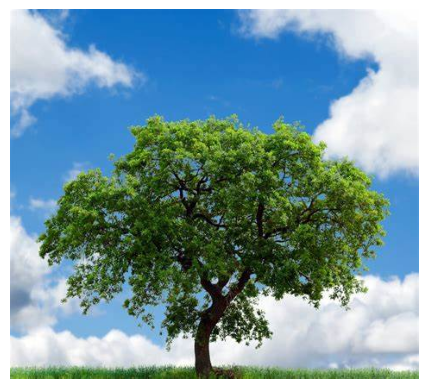

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, add
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

base_model = InceptionV3(weights='imagenet')
feature_extractor = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

def extract_features(image_path, model):
    """Extracts features from an image using InceptionV3."""
    try:
        image = Image.open(image_path).convert("RGB").resize((299, 299))
        image = np.array(image, dtype=np.float32)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)

        if np.all(feature == 0):
            print("Warning: Feature extraction failed.")
            return None
        return feature
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

dataset_path = "captions.txt"

with open(dataset_path, "r", encoding="utf-8") as file:
    dataset_text = file.read()

descriptions = {}

for line in dataset_text.strip().split('\n'):
    parts = line.split('\t', 1) if '\t' in line else line.split(' ', 1)
    if len(parts) < 2:
        continue

    image_id, caption = parts
    image_id = image_id.split('.')[0]
    descriptions.setdefault(image_id, []).append(f"<start> {caption.lower()} <end>")

if not descriptions:
    raise ValueError("No valid captions found. Check dataset format.")

tokenizer = Tokenizer()
all_captions = [caption for captions in descriptions.values() for caption in captions]
tokenizer.fit_on_texts(all_captions)

vocab_size = len(tokenizer.word_index) + 1
max_length = max((len(caption.split()) for caption in all_captions), default=1)

def create_sequences(image_features, captions, tokenizer, max_length):
    """Creates training sequences for captioning model."""
    X_image, X_seq, y = [], [], []
    for caption in captions:
        sequence = tokenizer.texts_to_sequences([caption])[0]
        for i in range(1, len(sequence)):
            X_image.append(image_features)
            X_seq.append(pad_sequences([sequence[:i]], maxlen=max_length, padding='post')[0])
            y.append(sequence[i])
    return np.array(X_image), np.array(X_seq), np.array(y)

embedding_dim = 256
inputs1 = tf.keras.layers.Input(shape=(2048,))
drop1 = Dropout(0.5)(inputs1)
dense1 = Dense(256, activation='relu')(drop1)

inputs2 = tf.keras.layers.Input(shape=(max_length,))
embedding2 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)

lstm2 = LSTM(256, return_sequences=False)(embedding2)

decoder = add([dense1, lstm2])
decoder = Dense(256, activation='relu')(decoder)
decoder = Dense(vocab_size, activation='softmax')(decoder)

model = Model(inputs=[inputs1, inputs2], outputs=decoder)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

X_image_train, X_seq_train, y_train = [], [], []
for image_id, captions in descriptions.items():
    feature = extract_features(f"images/{image_id}.jpg", feature_extractor)
    if feature is None:
        continue

    img_feats, seqs, targets = create_sequences(feature, captions, tokenizer, max_length)
    X_image_train.extend(img_feats)
    X_seq_train.extend(seqs)
    y_train.extend(targets)

X_image_train = np.array(X_image_train)
X_seq_train = np.array(X_seq_train)
y_train = np.array(y_train)

if len(X_image_train) > 0:
    print("Training Model...")
    model.fit([X_image_train, X_seq_train], y_train, epochs=20, batch_size=32, verbose=1)
else:
    print("Error: No training data. Check dataset.")

def sample_prediction(predictions, temperature=1.0):
    """Returns a word index based on temperature sampling."""
    predictions = np.asarray(predictions).astype("float64")
    predictions = np.log(predictions + 1e-8) / temperature
    exp_preds = np.exp(predictions)
    probabilities = exp_preds / np.sum(exp_preds)
    return np.random.choice(len(probabilities), p=probabilities)

def generate_caption(model, tokenizer, image_path, max_length, temperature=0.7):
    """Generates a caption for an image using the trained model."""
    feature = extract_features(image_path, feature_extractor)
    if feature is None:
        return "Error: Could not process image."

    input_text = "<start>"
    caption_words = []

    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([input_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

        prediction = model.predict([feature, sequence], verbose=0)[0]

        predicted_index = sample_prediction(prediction, temperature)
        predicted_word = tokenizer.index_word.get(predicted_index, "")

        if not predicted_word or predicted_word == "<end>":
            break

        caption_words.append(predicted_word)
        input_text += " " + predicted_word

    return " ".join(caption_words)

image_url = "https://th.bing.com/th/id/OIP.XeDp5SDJJL5ajss_JDzjMgHaGt?rs=1&pid=ImgDetMain"
response = requests.get(image_url)
image_path = "sample.jpg"

with open(image_path, "wb") as file:
    file.write(response.content)

caption = generate_caption(model, tokenizer, image_path, max_length)
print("Generated Caption:", caption)

img = Image.open(image_path)
plt.imshow(img)
plt.axis("off")
plt.show()